In [51]:
import numpy as np
from numpy.linalg import det
from numpy.linalg import inv
from numpy import mat
from numpy import random
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data = pd.read_csv('Data/Regression.csv')
x_train = data['x'].values
y_train = data['y'].values

## 1. Linear Regression

Loss function：
$$L(w) = \frac{1}{2M}\sum_{i=1}^{m}(y-x_iw)^2$$

闭解式：$W=(X^TX)^{-1}X^TY$
    
如果 $X^TX$ 没有逆矩阵， 则不能使用这种方法，可以采用梯度下降等优化方法求近似解


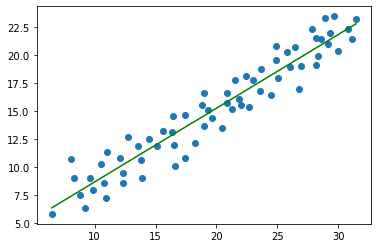

In [6]:
def linearRegression():
    x_mat = mat(x_train).T
    y_mat = mat(y_train).T
    [m,n] = x_mat.shape
    x_mat = np.hstack((x_mat, mat(np.ones((m,1)))))
    weight = mat(random.rand(n+1, 1))
    if det(x_mat.T*x_mat) == 0:
        print('the det of xTx is equal to zero')
        return
    else:
        weight = inv(x_mat.T*x_mat) * x_mat.T*y_mat
    
    x_min = x_train.min()
    x_max = x_train.max()
    y_min = weight[0]*x_min + weight[1]
    y_max = weight[0]*x_max + weight[1]
    plt.scatter(x_train, y_train)
    plt.plot([x_min, x_max],[y_min[0,0],y_max[0,0]],'-g')
    plt.show()
    
linearRegression() 

## 2. Ridge regression

add regularization for linear regression

Loss function:
$$L(w) = \frac{1}{2m}\sum_{i=1}^{m}(y-x_iw)^2 + \lambda\sum_{i=1}^{n}w_{i}^2$$

闭解式：$W = (X^TX + \lambda{I})^{-1}X^TY$

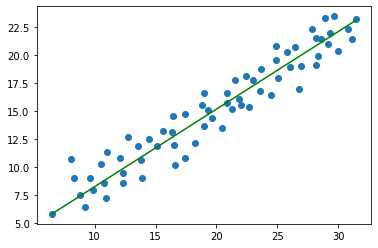

In [13]:
def ridgeRegression(x_train, y_train, lam = 0.2):
    x_mat = mat(x_train).T
    [m,n] = np.shape(x_mat)
    x_mat = np.hstack((x_mat, mat(np.ones((m,1)))))
    y_mat = mat(y_train).T
    
    weight = mat(random.rand(n+1,1))
    xTx = x_mat.T * x_mat + lam * mat(np.eye(n))
    
    if det(xTx) == 0:
        print('the det of xTx is zero')
        return
    weight = xTx.I * x_mat.T * y_mat
    
    x_min = x_train.min()
    x_max = x_train.max()
    y_min = weight[0]*x_min + weight[1]
    y_max = weight[0]*x_max + weight[1]
    plt.scatter(x_train, y_train)
    plt.plot([x_min, x_max],[y_min[0,0],y_max[0,0]],'-g')
    plt.show()
    

ridgeRegression(x_train, y_train, lam = 3)

## 3. Lasso regression

add l1 regularization

Loss function:

$$L(w) = \frac{1}{2m}\sum_{i=1}^{m}(y-x_iw)^2 + \lambda \sum_{i=1}^{n}\left | w_i \right |$$

这里不能采用闭解式， 可以采用向前逐步回归。

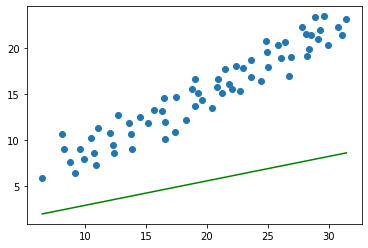

In [46]:
def lasso_regression(x_train, y_train, eps=0.001, itr_num=1000):
    x_mat = mat(x_train).T
    [m,n] = np.shape(x_mat)
    x_mat = (x_mat - x_mat.mean(axis = 0))/x_mat.std(axis=0)
    x_mat = np.hstack((x_mat, mat(np.ones((m, 1)))))
    y_mat = mat(y_train).T
    y_mat = (y_mat - y_mat.mean(axis = 0))/y_mat.std(axis=0)
    weight = mat(random.rand(n+1, 1))
    best_weight = weight.copy()
    
    for i in range(itr_num):
#         print(weight.T)
        lowest_error = np.inf
        for j in range(n+1):
            for sign in [-1,1]:
                weight_copy = weight.copy()
                weight_copy[j] += eps*sign
                y_predict = x_mat * weight_copy
                error = np.power(y_mat - y_predict,2).sum()
                if error < lowest_error:
                    lowest_error = error
                    best_weight = weight_copy
    
    weight = best_weight
    
    x_min = x_train.min()
    x_max = x_train.max()
    y_min = weight[0]*x_min + weight[1]
    y_max = weight[0]*x_max + weight[1]
    plt.scatter(x_train, y_train)
    plt.plot([x_min, x_max],[y_min[0,0],y_max[0,0]],'-g')
    plt.show()

lasso_regression(x_train, y_train)


## 4. 局部加权线性回归

给待测点附近等每个点赋予一定的权重。

损失函数：

$$L(\theta ) = \frac{1}{2M}\sum_{i=1}^{m}w_i(y-x_i\theta)^2$$

其中， $w_i$表示第i个样本的权重。

局部加权线性回归使用“核”来对附近对点赋予更高的权重。核的类型可以自由选择，最常用的核就是高斯核，高斯核对应的权重如下：

$$exp(\frac{\left | w_i-x \right |}{-2k^2})$$

这样就有一个只含对角元素的权重矩阵W，并且点$x_i$与x越近，$w_i$也会越大。这里的参数k决定了对附近的点赋予多大的权重，这也是唯一需要考虑的参数。

当k越大，有越多的点被用于训练回归模型；
当k越小，有越少的点用于训练回归模型。

In [53]:
def locally_weighted_linear_regression(test_point, x_train, y_train, k=1.0):
    x_mat = mat(x_train).T
    [m,n] = x_mat.shape
    x_mat = np.hstack((x_mat, mat(np.ones((m, 1)))))
    y_mat = mat(y_train).T
    
    weight = mat(np.zeros((n+1, 1)))
    y_predict = mat(np.zeros((len(test_point), 1)))
    
    for i in range(len(test_point)):
        test_point_mat = mat(test_point[i])
        test_point_mat = np.hstack((test_point_mat, mat([[1]])))
        weights = mat(np.eye((m)))
        test_data = np.tile(test_point_mat, [m,1])
        distances = (test_data - x_mat) * (test_data - x_mat).T / (n+1)
        distances = np.exp(distances/ (-2* k **2))
        weights = np.diag(np.diag(distances))
        # weights = distances * weights
        xTx = x_mat.T * (weights * x_mat)
        if det(xTx) == 0:
            print('the det of xTx is equal to zero')
            return
        weight = xTx.I * x_mat.T * weights * y_mat
        y_predict[i] = test_point_mat * weight
    print(y_predict)

locally_weighted_linear_regression([[15],[20]], x_train, y_train,k=0.1)

[[12.04574803]
 [13.97649834]]


/Users/yingyinghuang/repos/ISLR_Python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
